In [1]:
#  [1] Imports and Configuration
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import random
from torchvision.transforms import functional as func
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Configuration
class Config:
    batch_size = 128
    num_epochs = 50
    lr = 1e-4
    num_source_domains = 5  # 0°, 30°, 60°
    source_domains = [15, 30, 45, 60, 75]
    target_domains = [0, 90]       # Unseen domain
    num_classes = 9                # Using number 9 as the unseen class

config = Config()

In [4]:
class RotatedMNIST(Dataset):
    def __init__(self, base_dataset, rotation_angles, indices):
        self.base_dataset = base_dataset
        self.rotation_angles = rotation_angles
        self.transform = transforms.ToTensor()

        if indices is not None:
            self.indices = indices
        else:
            self.indices = torch.arange(len(self.base_dataset))

    def __getitem__(self, index):
        real_index = self.indices[index]
        img, label = self.base_dataset[real_index]  
        rot = random.choice(self.rotation_angles)

        # Make sure img is a PIL Image
        if not hasattr(img, "rotate"):
            img = transforms.ToPILImage()(img)

        img = func.rotate(img, rot)
        img = self.transform(img)

        if rot == 0:
            domain = 6
        else:
            domain = int(rot / 15 - 1)

        return img, label, domain

    def __len__(self):
        return len(self.indices)


In [5]:
# Load base MNIST
train_base = torchvision.datasets.MNIST(root='~/bhavyaaa/datasets', train=True, download=False)
test_base = torchvision.datasets.MNIST(root='~/bhavyaaa/datasets', train=False, download=False)

In [6]:
train_indices = (train_base.targets != 9).nonzero().flatten()
test_indices = (test_base.targets != 9).nonzero().flatten()
unseen_train_indices = (train_base.targets == 9).nonzero().flatten()
unseen_test_indices = (test_base.targets == 9).nonzero().flatten()

In [7]:
# train_dataset = RotatedMNIST(train_base, config.source_domains, indices = train_indices)
# test_dataset = RotatedMNIST(test_base, config.target_domains, indices = test_indices)  # Unseen domain
# unseen_test_dataset = RotatedMNIST(test_base, config.target_domains, indices = unseen_test_indices)
# unseen_train_dataset = RotatedMNIST(train_base, config.source_domains, indices = unseen_train_indices)

train_dataset = RotatedMNIST(train_base, config.source_domains, indices = train_indices)
test_dataset = RotatedMNIST(test_base, config.target_domains, indices = test_indices)  # Unseen domain
unseen_test_dataset = RotatedMNIST(test_base, config.target_domains, indices = unseen_test_indices)
unseen_train_dataset = RotatedMNIST(train_base, config.source_domains, indices = unseen_train_indices)

In [8]:
train_domain_count = [0,0,0,0,0,0,0]
train_label_count = [0,0,0,0,0,0,0,0,0,0]
test_domain_count = [0,0,0,0,0,0,0]
test_label_count = [0,0,0,0,0,0,0,0,0,0]
unseen_train_domain_count = [0,0,0,0,0,0,0]
unseen_train_label_count = [0,0,0,0,0,0,0,0,0,0]
unseen_test_domain_count = [0,0,0,0,0,0,0]
unseen_test_label_count = [0,0,0,0,0,0,0,0,0,0]

for sample in train_dataset:
    train_domain_count[sample[2]] += 1
    train_label_count[sample[1]] += 1

print("Train Domain Count: ", train_domain_count)
print("Train Label Count: ", train_label_count)

for sample in test_dataset:
    test_domain_count[sample[2]] += 1
    test_label_count[sample[1]] += 1

print("Test Domain Count: ", test_domain_count)
print("Test Label Count: ", test_label_count)

for sample in unseen_train_dataset:
    unseen_train_domain_count[sample[2]] += 1
    unseen_train_label_count[sample[1]] += 1

print("Unseen Train Domain Count: ", unseen_train_domain_count)
print("Unseen Train Label Count: ", unseen_train_label_count)

for sample in unseen_test_dataset:
    unseen_test_domain_count[sample[2]] += 1
    unseen_test_label_count[sample[1]] += 1

print("Unseen Test Domain Count: ", unseen_test_domain_count)
print("Unseen Test Label Count: ", unseen_test_label_count)
# sample = train_dataset[57]
# print(f"Image shape: {sample[0].shape}")  # torch.Size([1, 28, 28])
# print(f"Label: {sample[1]}, Domain index: {sample[2]}")  # e.g., Label: 5, Domain: 1 (30°)

Train Domain Count:  [10718, 10790, 10853, 10846, 10844, 0, 0]
Train Label Count:  [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 0]
Test Domain Count:  [0, 0, 0, 0, 0, 4594, 4397]
Test Label Count:  [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 0]
Unseen Train Domain Count:  [1260, 1182, 1185, 1157, 1165, 0, 0]
Unseen Train Label Count:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 5949]
Unseen Test Domain Count:  [0, 0, 0, 0, 0, 489, 520]
Unseen Test Label Count:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1009]


In [9]:
# [3] Data Loaders with Stratified Sampling (Modified from [2])
train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle=True, num_workers=2)
unseen_train_loader = DataLoader(unseen_train_dataset, batch_size = config.batch_size, shuffle=True, num_workers=2)
unseen_test_loader = DataLoader(unseen_test_dataset, batch_size = config.batch_size, shuffle=True, num_workers=2)

In [37]:
#  [4] Model Architecture (Domain-Adversarial + Evidential)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(1600, 128)  # Adjusted for MNIST size

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

class DomainClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.grl = GradientReversal.apply
        self.net = nn.Sequential(
            nn.Linear(128, 50), nn.ReLU(),
            nn.Linear(50, len(config.source_domains))
        )

    def forward(self, x, alpha=1.0):
        x = self.grl(x, alpha)
        return self.net(x)

class EvidentialHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(128, config.num_classes)

    def forward(self, x):
        evidence = torch.relu(self.fc(x))  # Use ReLU, not exp
        alpha = evidence + 1.0             # Dirichlet prior
        return alpha

In [38]:
#  [5] FIXED-style Mixup (Adapted from [3] concept)
def fixed_mixup(x1, x2, y1, y2, d1, d2):
    """Mix samples from same class but different domains"""
    if y1 == y2 and d1 != d2:
        lam = np.random.beta(0.2, 0.2)
        mixed_x = lam * x1 + (1 - lam) * x2
        return mixed_x, y1, lam
    return None

In [39]:
class EvidentialLoss(nn.Module):
    def __init__(self, coeff=1.0, kl_coeff=0.1):
        super().__init__()
        self.coeff = coeff
        self.kl_coeff = kl_coeff

    def forward(self, alpha, targets):
        S = torch.sum(alpha, dim=1, keepdim=True)
        p = alpha / S

        # 1) Negative log likelihood
        ce_loss = -torch.sum(targets * torch.log(p), dim=1)

        # 2) Evidence mismatch penalty
        error = (targets - p) ** 2
        var = p * (1 - p) / (S + 1)
        mse_loss = torch.sum(error + var, dim=1)

        # KL divergence with Dirichlet prior (1,...,1)
        kl = self.kl_divergence(alpha)

        total_loss = ce_loss + self.coeff * mse_loss + self.kl_coeff * kl
        return total_loss.mean()

    def kl_divergence(self, alpha):
        K = alpha.size(1)
        beta = torch.ones((1, K)).to(alpha.device)
        S_alpha = torch.sum(alpha, dim=1, keepdim=True)
        S_beta = torch.sum(beta, dim=1, keepdim=True)

        lnB = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alpha), dim=1, keepdim=True)
        lnB_uni = torch.sum(torch.lgamma(beta), dim=1, keepdim=True) - torch.lgamma(S_beta)

        dg0 = torch.digamma(S_alpha)
        dg1 = torch.digamma(alpha)

        kl = torch.sum((alpha - beta) * (dg1 - dg0), dim=1, keepdim=True) + lnB + lnB_uni
        return kl.squeeze()


In [40]:
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor = FeatureExtractor().to(device)
    domain_classifier = DomainClassifier().to(device)
    evidential_head = EvidentialHead().to(device)

    optimizer = torch.optim.Adam(
        list(feature_extractor.parameters()) +
        list(domain_classifier.parameters()) +
        list(evidential_head.parameters()),
        lr=config.lr
    )

    criterion = EvidentialLoss(coeff=1.0, kl_coeff=0.1)

    for epoch in range(config.num_epochs):
        feature_extractor.train()
        domain_classifier.train()
        evidential_head.train()

        for images, labels, domains in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            domains = domains.to(device)

            features = feature_extractor(images)

            # Domain classifier with gradient reversal
            p = epoch / config.num_epochs
            grl_alpha = 2 / (1 + np.exp(-10 * p)) - 1
            domain_preds = domain_classifier(features, alpha=grl_alpha)
            domain_loss = nn.CrossEntropyLoss()(domain_preds, domains)

            # Mixup: only if different domain same class
            mixed_features = []
            mixed_labels = []
            for i in range(0, len(images)-1, 2):
                mix_result = fixed_mixup(
                    features[i], features[i+1],
                    labels[i], labels[i+1],
                    domains[i], domains[i+1]
                )
                if mix_result:
                    mixed_x, mixed_y, _ = mix_result
                    mixed_features.append(mixed_x)
                    mixed_labels.append(mixed_y)

            # Pure evidential loss
            pure_alpha = evidential_head(features)
            pure_labels_onehot = nn.functional.one_hot(labels, config.num_classes).float().to(device)
            pure_loss = criterion(pure_alpha, pure_labels_onehot)

            # Mixed loss
            if mixed_features:
                mixed_features = torch.stack(mixed_features)
                mixed_labels = torch.tensor(mixed_labels, dtype=torch.long).to(device)
                mixed_alpha = evidential_head(mixed_features)
                mixed_labels_onehot = nn.functional.one_hot(mixed_labels, config.num_classes).float().to(device)
                mixed_loss = criterion(mixed_alpha, mixed_labels_onehot)
            else:
                mixed_loss = 0

            evidential_loss = pure_loss + mixed_loss
            total_loss = evidential_loss + 0.5 * domain_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{config.num_epochs} | "
              f"Total Loss: {total_loss.item():.4f} | "
              f"Evidential Loss: {evidential_loss.item():.4f} | "
              f"Domain Loss: {domain_loss.item():.4f}")

    return feature_extractor, evidential_head


In [ ]:
# #  [7] Training Loop
# def train_model():
#     feature_extractor = FeatureExtractor().to(device)
#     domain_classifier = DomainClassifier().to(device)
#     evidential_head = EvidentialHead().to(device)

#     optimizer = torch.optim.Adam([
#         {'params': feature_extractor.parameters(), 'lr': config.lr},
#         {'params': domain_classifier.parameters(), 'lr': config.lr},
#         {'params': evidential_head.parameters(), 'lr': config.lr * 0.1}
#     ])

#     criterion = EvidentialLoss()

#     for epoch in range(config.num_epochs):
#         for images, labels, domains in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             domains = domains.to(device)
            
            # # Feature extraction
            # features = feature_extractor(images)

            # # Domain classification
            # p = epoch / config.num_epochs
            # alpha = 2 / (1 + np.exp(-10 * p)) - 1
            # domain_preds = domain_classifier(features, alpha=alpha)
            # domain_loss = nn.CrossEntropyLoss()(domain_preds, domains)

            # # FIXED Mixup
            # mixed_features, mixed_labels = [], []

            # pair_limit = len(images) if len(images) % 2 == 0 else len(images) - 1
            # for i in range(0, pair_limit, 2):
            #     mix_result = fixed_mixup(features[i], features[i+1],
            #                            labels[i], labels[i+1],
            #                            domains[i], domains[i+1])
            #     if mix_result:
            #         mixed_x, mixed_y, _ = mix_result
            #         mixed_features.append(mixed_x)
            #         mixed_labels.append(mixed_y)
                    

            # # Evidential learning
            # pure_alpha = evidential_head(features)
            # pure_loss = criterion(pure_alpha, 
            #         nn.functional.one_hot(labels, config.num_classes).float())

            # if mixed_features:
            #     mixed_features = torch.stack(mixed_features).to(device)
            #     mixed_labels = torch.tensor(mixed_labels, dtype=torch.long, device=device)
    #             mixed_alpha = evidential_head(mixed_features)
    #             mixed_loss = criterion(mixed_alpha,
    #                 nn.functional.one_hot(mixed_labels, config.num_classes).float())
    #         else:
    #             mixed_loss = 0

    #         evidential_loss = pure_loss + mixed_loss

    #         # Total loss
    #         total_loss = domain_loss + 0.5 * evidential_loss

    #         # Backprop
    #         optimizer.zero_grad()
    #         total_loss.backward()
    #         optimizer.step()

    #     # Validation would go here
    #     print(f"Epoch {epoch+1}/{config.num_epochs} | Total Loss: {total_loss.item():.4f} | Evidential Loss: {evidential_loss.item():.4f} | Domain Loss: {domain_loss.item():.4f}")

    # return feature_extractor, evidential_head

In [41]:
feature_extractor, evidential_head = train_model()

Epoch 1/50 | Total Loss: 2.6793 | Evidential Loss: 2.0016 | Domain Loss: 1.3554
Epoch 2/50 | Total Loss: 3.8796 | Evidential Loss: 3.1401 | Domain Loss: 1.4790
Epoch 3/50 | Total Loss: 2.3829 | Evidential Loss: 1.6109 | Domain Loss: 1.5440
Epoch 4/50 | Total Loss: 3.5556 | Evidential Loss: 2.7663 | Domain Loss: 1.5787
Epoch 5/50 | Total Loss: 3.6709 | Evidential Loss: 2.9070 | Domain Loss: 1.5278
Epoch 6/50 | Total Loss: 3.7617 | Evidential Loss: 2.9441 | Domain Loss: 1.6352
Epoch 7/50 | Total Loss: 3.7866 | Evidential Loss: 2.9389 | Domain Loss: 1.6953
Epoch 8/50 | Total Loss: 3.5467 | Evidential Loss: 2.7829 | Domain Loss: 1.5276
Epoch 9/50 | Total Loss: 3.5226 | Evidential Loss: 2.7340 | Domain Loss: 1.5772
Epoch 10/50 | Total Loss: 2.3654 | Evidential Loss: 1.5673 | Domain Loss: 1.5962
Epoch 11/50 | Total Loss: 2.3322 | Evidential Loss: 1.5165 | Domain Loss: 1.6314
Epoch 12/50 | Total Loss: 3.4329 | Evidential Loss: 2.6076 | Domain Loss: 1.6505
Epoch 13/50 | Total Loss: 3.5195 | Ev

In [42]:
#  [8] Evaluation Metrics (From [3] and [5] concepts)
def seen_evaluate(feature_extractor, evidential_head, loader):
    feature_extractor.eval()
    evidential_head.eval()

    correct = 0
    total = 0
    uncertainties = []
    all_preds = []
    all_labels = []
    correct_uncertainties = []
    incorrect_uncertainties = []

    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)

            features = feature_extractor(images)
            alpha = evidential_head(features)

            # Predictions
            preds = torch.argmax(alpha, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            # Uncertainty (total evidence)
            S = torch.sum(alpha, dim=1)
            sample_uncertainty = (config.num_classes / S).cpu().tolist()
            uncertainties.extend(sample_uncertainty)

            # Split by correctness
            correct_mask = (preds == labels)
            for u, is_correct in zip(sample_uncertainty, correct_mask.cpu()):
                if is_correct:
                    correct_uncertainties.append(u)
                else:
                    incorrect_uncertainties.append(u)

            correct += correct_mask.sum().item()
            total += len(labels)

    cm = confusion_matrix(all_labels, all_preds)
    acc = correct / total
    avg_uncertainty = np.mean(uncertainties)
    print(f"Test Accuracy: {acc*100:.2f}% | Avg Uncertainty: {avg_uncertainty:.4f}")

    return acc, avg_uncertainty, cm, correct_uncertainties, incorrect_uncertainties

In [43]:
#  [8] Evaluation Metrics (From [3] and [5] concepts)
def unseen_evaluate(feature_extractor, evidential_head, loader):
    feature_extractor.eval()
    evidential_head.eval()

    uncertainties = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, _, _ in loader:
            images = images.to(device)
            features = feature_extractor(images)
            alpha = evidential_head(features)

            # Predictions
            preds = torch.argmax(alpha, dim=1)
            all_preds.extend(preds.cpu().tolist())

            # Uncertainty (total evidence)
            S = torch.sum(alpha, dim=1)
            sample_uncertainty = (config.num_classes / S).cpu().tolist()
            uncertainties.extend(sample_uncertainty)

    avg_uncertainty = np.mean(uncertainties)
    print(f"Avg Uncertainty: {avg_uncertainty:.4f}")

   # ---- Combined Figure ----
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # 2️⃣ Histogram: correct
    axes[0].hist(uncertainties, bins=30, alpha=0.7, color='green')
    axes[0].set_title("Uncertainties")
    axes[0].set_xlabel("Uncertainty")
    axes[0].set_ylabel("Count")

    # 3️⃣ Histogram: incorrect
    axes[1].hist(all_preds, bins=9, alpha=0.7, color='red')
    axes[1].set_title("Predictions")
    axes[1].set_xlabel("Labels")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

Test Accuracy: 88.32% | Avg Uncertainty: 0.4400


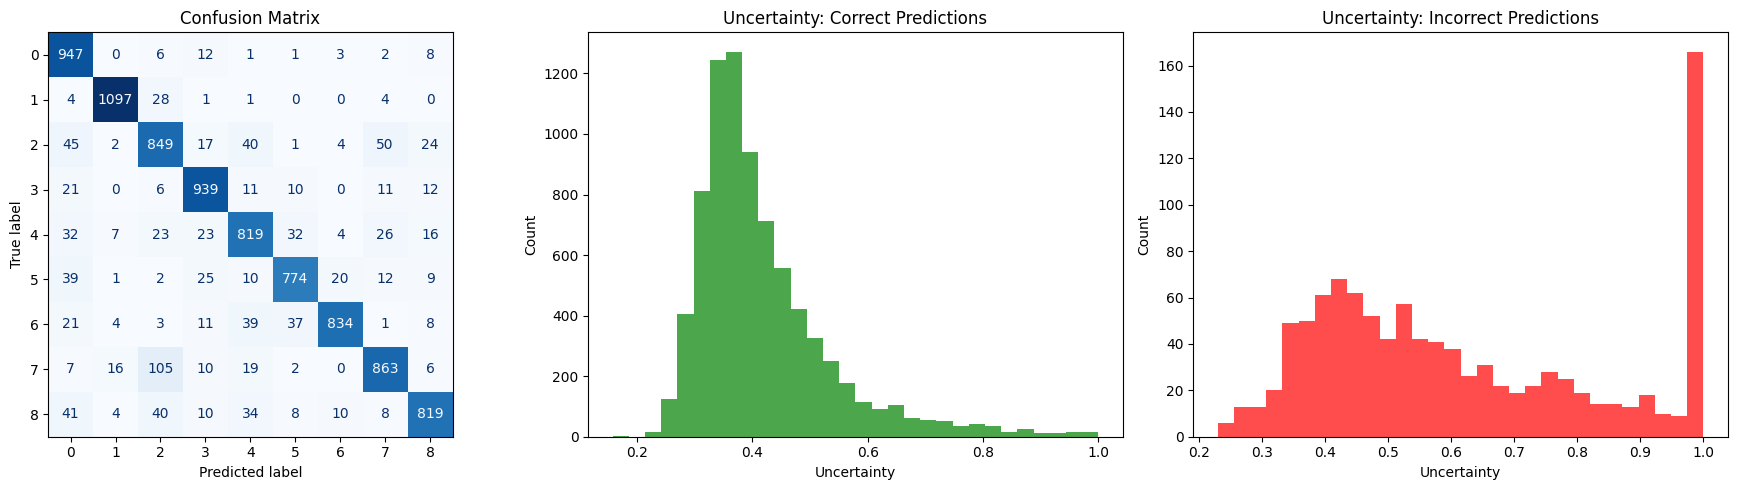

In [44]:
acc, avg_uncertainty, cm, correct_uncertainties, incorrect_uncertainties = seen_evaluate(feature_extractor, evidential_head, test_loader)

# ---- Combined Figure ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1️⃣ Confusion Matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Confusion Matrix")

# 2️⃣ Histogram: correct
axes[1].hist(correct_uncertainties, bins=30, alpha=0.7, color='green')
axes[1].set_title("Uncertainty: Correct Predictions")
axes[1].set_xlabel("Uncertainty")
axes[1].set_ylabel("Count")

# 3️⃣ Histogram: incorrect
axes[2].hist(incorrect_uncertainties, bins=30, alpha=0.7, color='red')
axes[2].set_title("Uncertainty: Incorrect Predictions")
axes[2].set_xlabel("Uncertainty")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

Avg Uncertainty: 0.5952


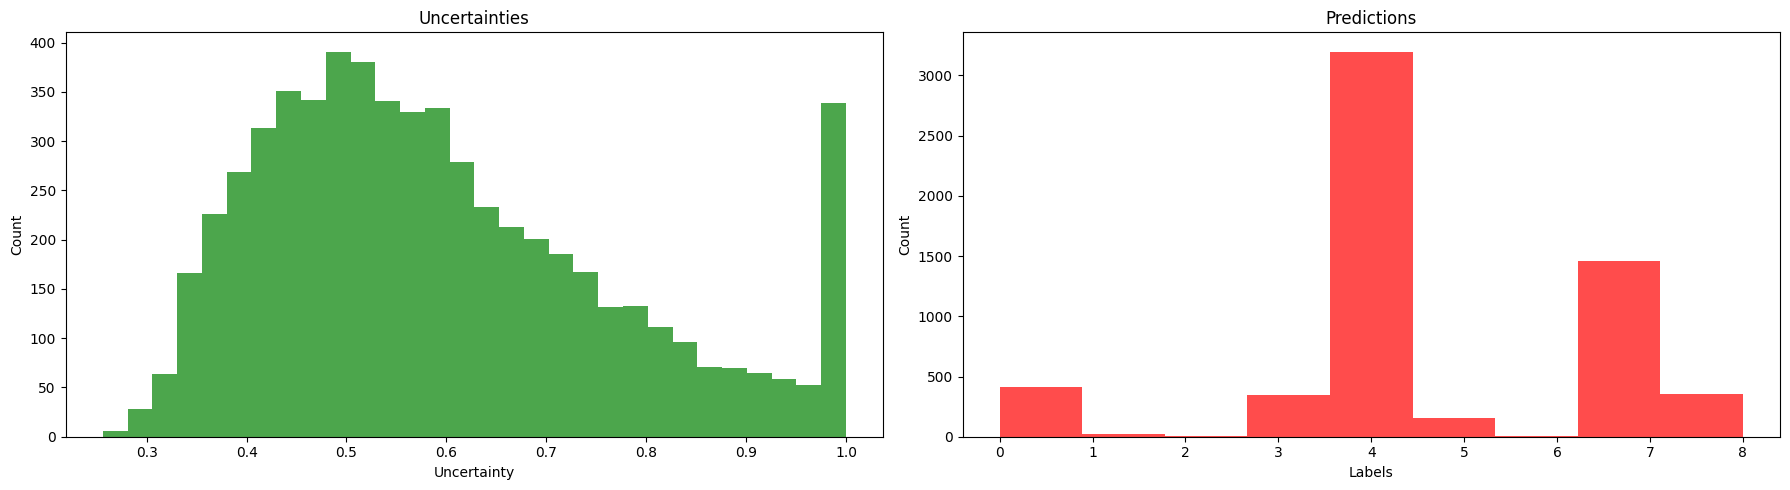

In [45]:
unseen_evaluate(feature_extractor, evidential_head, unseen_train_loader)

Avg Uncertainty: 0.6430


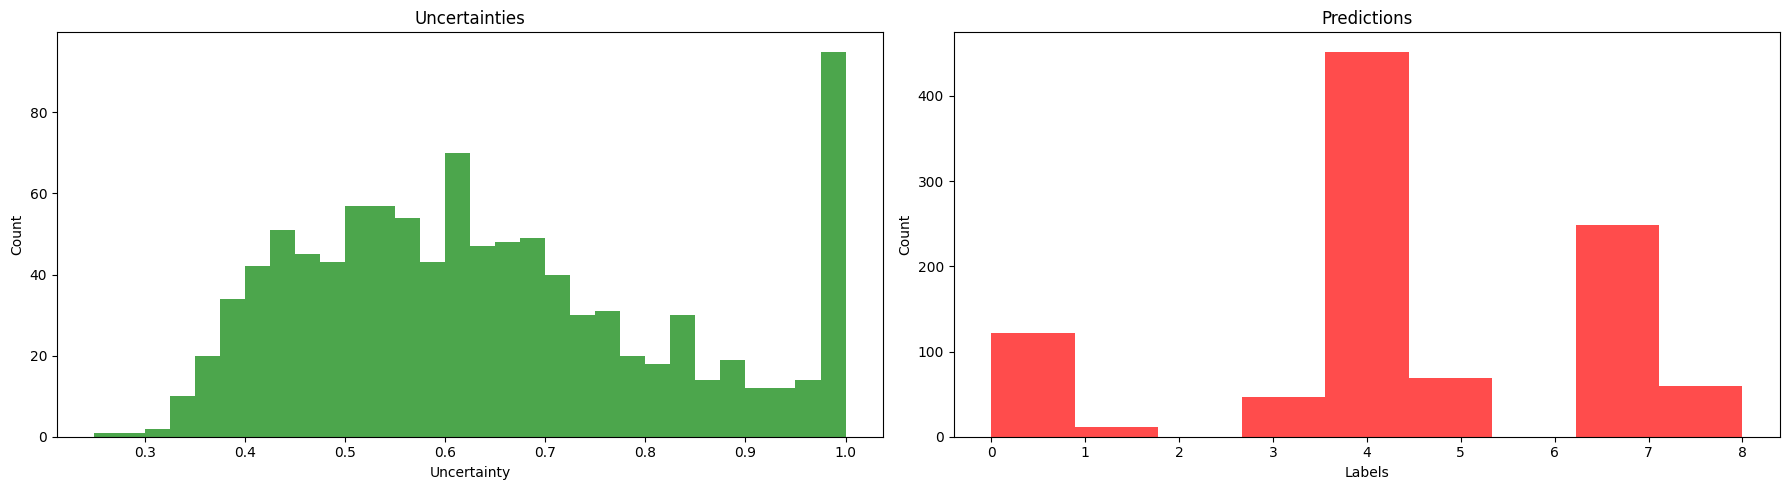

In [46]:
unseen_evaluate(feature_extractor, evidential_head, unseen_test_loader)